In [1]:
import bz2

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
INDEX = ['Android', 'Visual Studio Code', 'React', 'Microsoft', 'Spotify', 'Trivago',]

In [3]:
def load_minimal_distance(file_path: str) -> pd.DataFrame:
    with bz2.BZ2File(file_path, 'rb') as file:
        return pd.read_pickle(file)

In [4]:
OPEN_SOURCE = ['Android', 'Visual Studio Code', 'React',]
CLOSED_SOURCE = ['Microsoft', 'Spotify', 'Trivago',]

In [5]:
all_minimal_distances = {
    'Android': load_minimal_distance('../data/minimal_distances/android.pickle.bz2'),
    'Visual Studio Code': load_minimal_distance('../data/minimal_distances/vscode.pickle.bz2'),
    'React': load_minimal_distance('../data/minimal_distances/react.pickle.bz2'),
    'Microsoft': load_minimal_distance('../data/minimal_distances/microsoft.pickle.bz2'),
    'Spotify': load_minimal_distance('../data/minimal_distances/spotify.pickle.bz2'),
    'Trivago': load_minimal_distance('../data/minimal_distances/trivago.pickle.bz2'),
}

In [6]:
def compute_ranges(minimal_distances, name, normalize):
    c = minimal_distances.groupby(level=0, observed=False).shortest.count()
    if normalize:
        num_participants = minimal_distances.index.get_level_values(0).categories.size
        c = (c/num_participants).round(decimals=2)
    cc = c.value_counts(normalize=True).sort_index()
    index = None
    if normalize:
        index = np.arange(0, cc.index.max()+0.001, step=0.01)
        s = cc.reindex(index, fill_value=0, tolerance=0.001, method='nearest')
    else:
        index = np.arange(0, cc.index.max()+1, step=1, dtype=np.int64)
        s = cc.reindex(index, fill_value=0)
    s.index.rename('range', inplace=True)
    return s.sort_index().cumsum().rename(name)

# Normalized Information Diffusion Range

In [7]:
normalized_ranges = pd.concat([compute_ranges(minimal_distances, name, normalize=True) for name, minimal_distances in all_minimal_distances.items()], axis=1).sort_index()

In [8]:
normalized_ranges['os_min'] = normalized_ranges[OPEN_SOURCE].min(axis=1)
normalized_ranges['os_max'] = normalized_ranges[OPEN_SOURCE].fillna(1.0).max(axis=1)
normalized_ranges['cs_min'] = normalized_ranges[CLOSED_SOURCE].min(axis=1)
normalized_ranges['cs_max'] = normalized_ranges[CLOSED_SOURCE].fillna(1.0).max(axis=1)

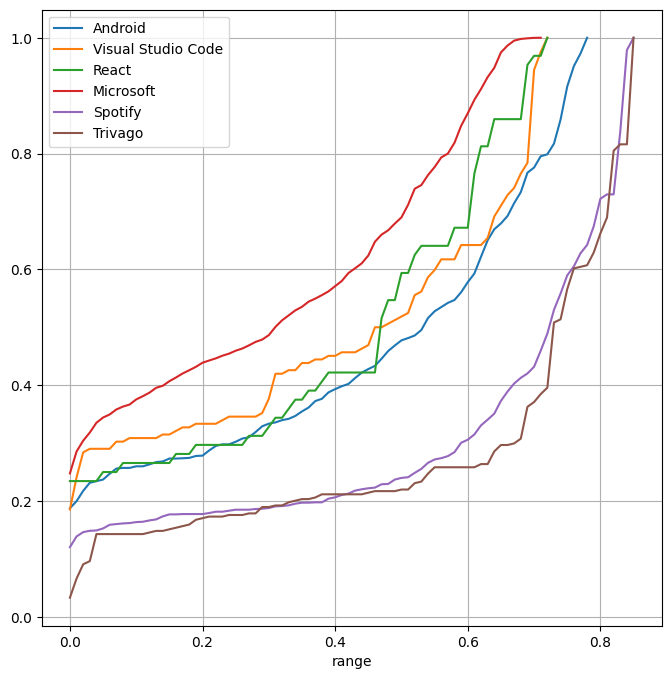

In [9]:
fig, ax = plt.subplots(figsize=(8,8), dpi=100)
normalized_ranges[OPEN_SOURCE + CLOSED_SOURCE].plot(ax=ax)

plt.grid('both')

In [10]:
normalized_ranges.to_csv('../reports/csv/ranges.csv', index_label='index', float_format='%g')

In [11]:
l = []
m = normalized_ranges.idxmax().rename('max')
for i in [0.3, 0.5, 0.7, 0.9]:
    name = f'\\numrange{{{i:.1f}}}{{1.0}}'
    l += [pd.Series({i: f'\\numrange{{{v:0.2f}}}{{{m[i]:0.2f}}}' for i, v in normalized_ranges[normalized_ranges <= i].idxmax().rename(name).to_dict().items()}, name=name)]
df = pd.concat(l, axis=1).reindex(INDEX)
df.columns = pd.MultiIndex.from_product([['Quantile range'], df.columns])

with open('../reports/tex/normalized_ranges.tex', 'w') as file:
   df.to_latex(file, multicolumn_format='l')
df

Quantile range                         \
                      \numrange{0.3}{1.0}    \numrange{0.5}{1.0}   
Android             \numrange{0.23}{0.78}  \numrange{0.53}{0.78}   
Visual Studio Code  \numrange{0.03}{0.72}  \numrange{0.45}{0.72}   
React               \numrange{0.19}{0.72}  \numrange{0.39}{0.72}   
Microsoft           \numrange{0.01}{0.71}  \numrange{0.30}{0.71}   
Spotify             \numrange{0.58}{0.85}  \numrange{0.72}{0.85}   
Trivago             \numrange{0.67}{0.85}  \numrange{0.72}{0.85}   

                                                                  
                      \numrange{0.7}{1.0}    \numrange{0.9}{1.0}  
Android             \numrange{0.66}{0.78}  \numrange{0.74}{0.78}  
Visual Studio Code  \numrange{0.64}{0.72}  \numrange{0.69}{0.72}  
React               \numrange{0.58}{0.72}  \numrange{0.64}{0.72}  
Microsoft           \numrange{0.50}{0.71}  \numrange{0.61}{0.71}  
Spotify             \numrange{0.79}{0.85}  \numrange{0.83}{0.85}  
Trivago             \numrange{0.81}{0.85}  \numrange{0.83}{0.85}

# Absolute Information Diffusion Range

In [12]:
ranges = pd.concat([compute_ranges(minimal_distances, name, normalize=False) for name, minimal_distances in all_minimal_distances.items()], axis=1).sort_index()

In [13]:
l = []
m = ranges.idxmax().rename('max')
for i in [0.3, 0.5, 0.7, 0.9]:
    name = f'\\numrange{{{i:.1f}}}{{1.0}}'
    l += [pd.Series({i: f'\\numrange{{{v}}}{{{m[i]}}}' for i, v in ranges[ranges <= i].idxmax().rename(name).round(decimals=2).to_dict().items()}, name=name)]
df = pd.concat(l, axis=1).reindex(INDEX)

df.columns = pd.MultiIndex.from_product([['Quantile range'], df.columns])

with open('../reports/tex/ranges.tex', 'w') as file:
    df.to_latex(file, multicolumn_format='l')
df

Quantile range                           \
                      \numrange{0.3}{1.0}      \numrange{0.5}{1.0}   
Android              \numrange{448}{1407}     \numrange{966}{1407}   
Visual Studio Code      \numrange{5}{116}       \numrange{74}{116}   
React                   \numrange{12}{46}        \numrange{25}{46}   
Microsoft           \numrange{808}{26216}  \numrange{11645}{26216}   
Spotify             \numrange{1026}{1472}    \numrange{1260}{1472}   
Trivago               \numrange{245}{310}      \numrange{266}{310}   

                                                                      
                        \numrange{0.7}{1.0}      \numrange{0.9}{1.0}  
Android               \numrange{1197}{1407}    \numrange{1344}{1407}  
Visual Studio Code      \numrange{104}{116}      \numrange{113}{116}  
React                     \numrange{37}{46}        \numrange{41}{46}  
Microsoft           \numrange{18887}{26216}  \numrange{22983}{26216}  
Spotify               \numrange{1386}{1472}    \numrange{1447}{1472}  
Trivago                 \numrange{296}{310}      \numrange{309}{310}